# Exploration 14

## 프로젝트 : 주식 예측에 도전해 보자
### |프로젝트 학습 과정

1. 시계열 데이터 준비
2. 데이터 전처리
3. 시계열 정상성 분석
    - 정성적 그래프 분석
    - 정량적 Augmented Dicky-Fuller Test
    - 시계열 분해(Time Series Decomposition)
    - Residual 안정성 확인
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기

### |프로젝트 평가
| |평가문항|상세기준|
|------|---|---|
|1|시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2| ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|gp,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3| 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?| 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

[Yahoo Finance](https://finance.yahoo.com/)에서 데이터셋을 다운로드 받을 수 있습니다! 저는 TSLA 데이터를 다운 받아서 해보겠습니다.

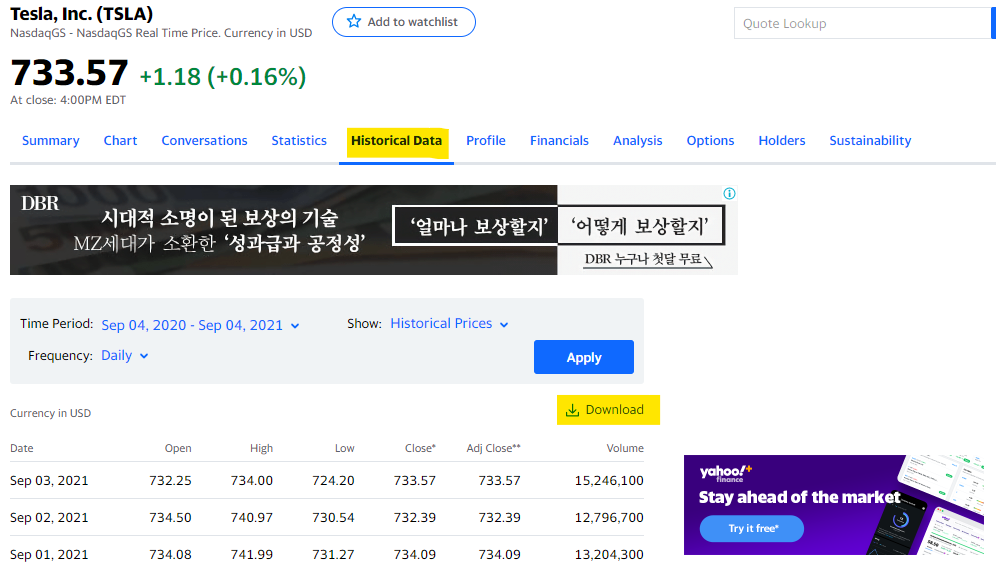

# Data Info

1. 컬럼 종류: Data, Open, High, Low, Close, Adj Close, Volume
2. 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 증가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음
3. 이 프로젝트에서는 종가(Close)만 사용할 예정

* 종가(Close)란 하루의 장이 마감할 때 가격

# 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'

# index_col=['column_name']으로 설정해주면 날짜/시간을 pandas의 DataFrame의 index로 바로 읽어올 수 있습니다.
# parse_dates=['date'] 처럼 명시적으로 칼럼 이름을 설정하는 방법도 가능
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# 2. 데이터 전처리

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


### 결측치 확인

In [3]:
# pandas.DataFrame.interpolate(): time 메서드를 보간한다.
ts = ts.interpolate(method='time')

# Time Series에서 결측치가 있는 부분만 Series로 출력해보기
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

결측치 없음

### 로그 변환

In [4]:
ts_log = np.log(ts)
ts_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

### 1차 차분

In [5]:
ts_diff = np.diff(ts)
ts_diff

array([ 1500.,  -300.,   -50., -1200.,   100.,   400.,   650.,   500.,
         300.,   500.,   200.,  3100.,   100.,   900.,  -600.,   600.,
        -100., -1100., -2000., -2400.,  2200.,   100.,   100.,   600.,
        -900.,  -600.,  1500., -1000.,  1400.,  -900.,   400.,  -200.,
         300.,   700.,  1400., -1600.,  -400.,  -200.,  -100.,   700.,
         400.,   900.,  -900.,   600.,  -200.,  1100.,  -600.,  -600.,
         100.,  1400.,  3000.,   400.,     0., -1100., -1100.,   500.,
        -400.,  1100.,  -500.,   300.,   400.,   800.,  -300.,  -700.,
         400.,  -600., -2400.,   500.,   200.,   300.,     0.,  -800.,
        -200., -1400.,   200.,   200.,  2000.,  -800.,   900.,  2200.,
        -300.,   800.,  -200.,  1400.,   600.,     0., -1500.,  -200.,
        -100., -1000.,   400.,  -800.,   100.,   300.,     0.,   500.,
         300.,   900.,  -200.,   700.,   500.,     0.,  -900.,  -500.,
         500.,   900.,     0.,  -800.,   100.,   200.,  -600.,  -800.,
      

## Moving average 제거

In [35]:
mv_avg = ts_log.rolling(window=12).mean()
ts_log_mv_avg = ts_log - mv_avg # 변화량 제거
ts_log_mv_avg

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
                ...   
2021-05-12   -0.025240
2021-05-13   -0.039022
2021-05-14   -0.015982
2021-05-17   -0.019667
2021-05-18   -0.017497
Name: Close, Length: 250, dtype: float64

In [36]:
ts_log_mv_avg.dropna(inplace=True)

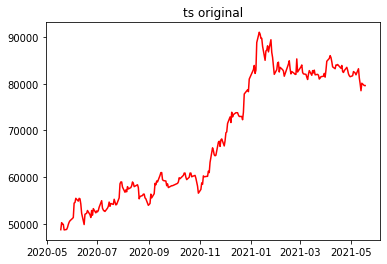

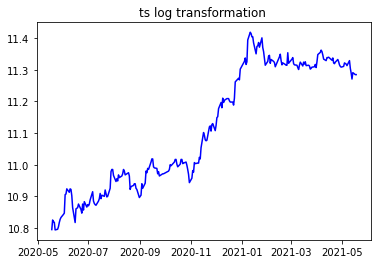

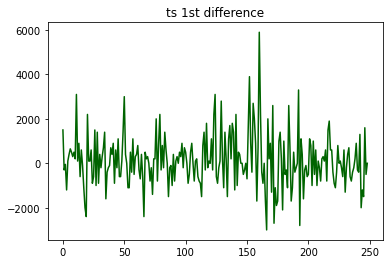

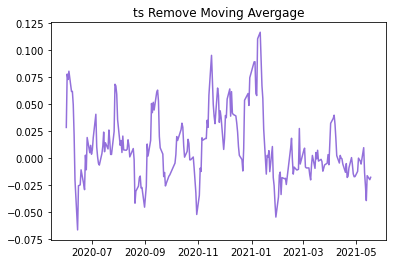

In [37]:
# ts Series
plt.plot(ts, color='red')
plt.title('ts original')
plt.show()

# 로그 변환한 ts
plt.plot(ts_log, color='blue')
plt.title('ts log transformation ')
plt.show()

# 1차 차분을 적용한 ts
plt.plot(ts_diff, color='darkgreen')
plt.title('ts 1st difference')
plt.show()

# 로그변환 시계열에 Moving Average 제거
plt.plot(ts_log_mv_avg, color='mediumpurple')
plt.title('ts Remove Moving Avergage')
plt.show()

# 3. 시계열 분석

## 정성적 분석

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    # 이동평균 시계열
    rolmean = timeseries.rolling(window=window).mean()
    # 이동표준편차 시계열
    rolstd = timeseries.rolling(window=window).std() 

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

## ADF 검정

- statsmodels 패키지, adfuller 메소드 사용

In [18]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

TypeError: adfuller() got an unexpected keyword argument 'autolog'   
혹시 위의 코드를 출력했을 때, 위와 같은 TypeError가 난다면 버전을 낮춰줘야 한다.

해당 코드를 시행해보기👇   
- pip install elasticsearch==5.5.3

In [19]:
pip install elasticsearch==5.5.3

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


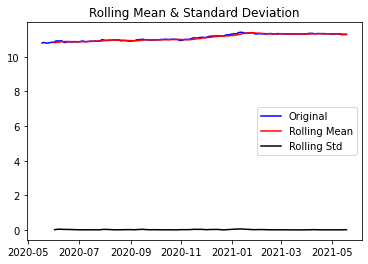

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [20]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

ADF Test는 시계열 데이터의 정상성을 테스트하는 방법입니다.

- 귀무가설: 주어진 시계열 데이터는 정상성을 띄지 않는다.
- 대립가설: 주어진 시계열 데이터가 정상성을 띈다.

p-value는 유의확률이라 합니다. 이는 귀무가설이 참일 때 관측된 검정통계량이 더 극단적으로 귀무가설에 반하여 나올 확률을 뜻합니다. 보통 95% 신뢰구간에서 오차 범위를 추정하며, 여기서 0.05이하의 p값에서 '유의미'(significant)하다고 표현합니다.

이에 따라, 여기서 p-value의 값이 0.590149로 나왔으니 매우 크니 귀무가설을 기각할 수 없습니다.

- 즉, 로그 변환한 시계열 데이터는 귀무가설을 채택! 👉 정상성을 띄지 않는다고 볼 수 있겠군요!

In [38]:
augmented_dickey_fuller_test(ts_log_mv_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


로그 변환한 시계열에 Moving average 제거하여 Trend를 상쇄한 ts_log_mv_avg입니다. 아까보다 p-value 수준이 0.000759로 많이 낮아졌음을 알 수 있습니다.

- 즉, 로그 변환한 시계열 데이터는 귀무가설을 기각 가능! 👉 정상성 시계열!

# 시계열 분해(STL Decompose)
- STL(Seasonal and Trend decomposition using Loess)

시계열 분해의 개념은 시계열적 특성을 갖는 데이터를 trend, seasonal, residual로 나누어 분석하는 방법입니다. 시계열 모델은 크게
- Additive
- Multiplicative   
의 두 가지 모델로 나눌 수 있습니다.

여기선 'Multiplicative 모델'을 사용할 것이고, 이것은
- origin = trend * seasonal * residual   
으로 나누어 분석한 모델입니다.

Multiplicative 모델을 사용할 때 주의 사항❗   
👉 데이터에 0이 존재하면 안 됩니다. 0이 존재하면 데이터를 분해할 수 없기 때문입니다.

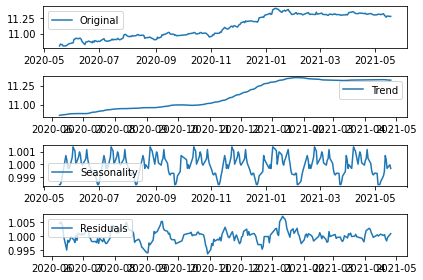

In [21]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Residual

In [22]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Residual(잔차)에서의  p-value의 값은  6.234854e-08으로 소숫점 자리로 8번 이동하면 이미 0.005 이하의 p값을 가져서 이 p값은 유의미(significant)하다고 볼 수 있겠군요. 즉, 정상성 시계열(Stationary Time-Series)이라 볼 수 있습니다.

# 4. 학습, 테스트 데이터셋 생성

- 분리 비율은 학습과 테스트에 9:1로 할당
- 시계열 예측이니까 가장 나중 데이터를 테스트용으로 사용하는 것이 타당함

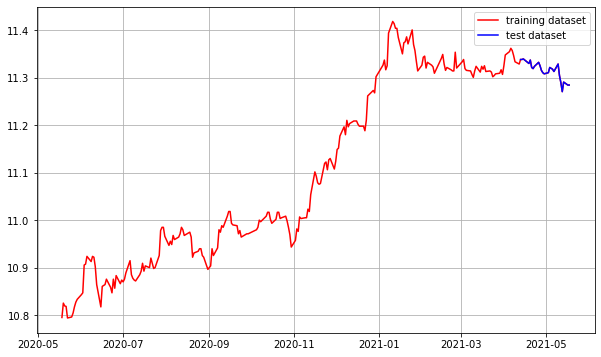

In [23]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


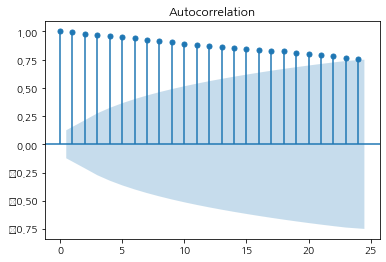

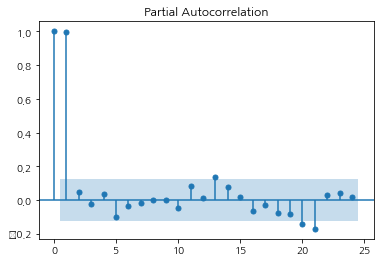

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF : Autocorrelation 그래프 그리기
plot_acf(ts_log)

# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(ts_log)
plt.show()

ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 설정해야 합니다. 이 파라미터가 올바른 예측식을 구하는데 핵심적인 요소가 됩니다!

ARIMA 모델의 모수에는 p, q, d가 있는데요. 이는   
- p : 자기회귀 모형(AR)의 시차
- q : 이동평균 모형(MA)의 시차
- d : 차분누적(I) 횟수

이 됩니다. p와 q는 일반적으로 p + q < 2, p * q=0인 값을 사용한다고 합니다. p와 q 중 하나는 0이라는 뜻인데, 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

그럼 다시 그래프를 살펴보며 모수의 값을 선택해 보겠습니다.

ACF 그래프를 보았을 때 값은 1에서 0.75까지 점차 작아지고 있습니다. 점차적으로 작아지는 AR(p) 모델과 동일합니다. 반면에 PACF 그래프도 시차 p 이후 값들은 모두 0에 치우쳐져 있습니다. 이는 p + q < 2, p * q=0를 만족하는 결과이며, AR(p) 모델을 사용할 수 있는 근거가 됩니다.

그래서 MA(q)보단 AR(p)의 모델에 가까워 이를 선택하였고 p 값은 1이 되었기 때문에 AR(1)이 됩니다.

위에서 말했듯이 현재는 MA를 고려할 필요가 사라졌습니다. 이젠 d를 고려해보아야 합니다. d는 몇 번 차분을 할 것이냐? 입니다. 일단 차분을 구해본 다음에 시계열이 정상성인지 판단해보면 됩니다!

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


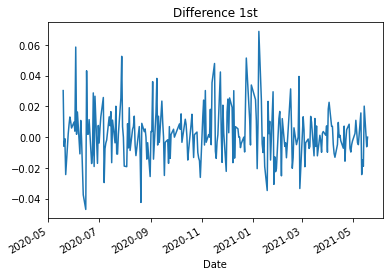

In [42]:
# 차분 안정성 확인, d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


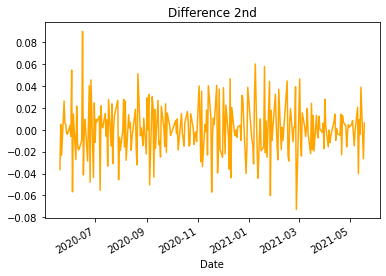

In [44]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd', color='orange')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

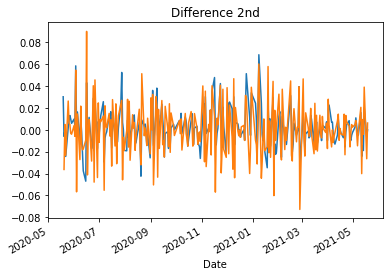

In [45]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

로그 변환 시 변동폭이 일정해지는 효과가 있으며, 차분을 했을 때 평균이 일정한 시계열로 변환합니다. 1차(파랑), 2차(주황) 차분을 비교해 보았을 때 평균과 분산이 더 일정한 시계열은 1차 차분으로 생각할 수 있겠습니다.

# 6. ARIMA 모델 훈련과 테스트

앞서 p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 사용하기로 하였습니다.

In [47]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1164.792
Time:                        02:06:52   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

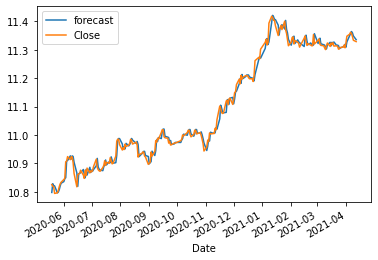

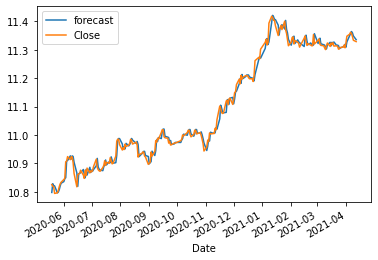

In [48]:
# ARIMA 모델 훈련 결과를 시각화
fitted_m.plot_predict()

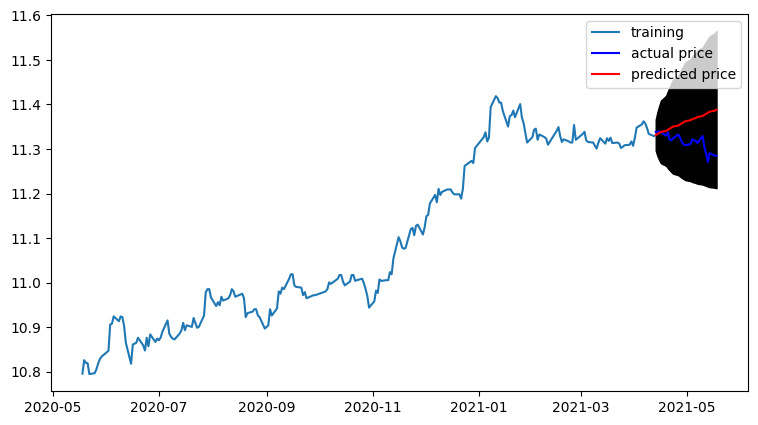

In [50]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
# Forecase : 결과가 fc에 담깁니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% Conf

# Make as pandas series
# 예측 결과
fc_series = pd.Series(fc, index=test_data.index)
# 예측 결과의 하향 바운드
lower_series =pd.Series(conf[:, 0], index=test_data.index)
# 예측 결과의 상향 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k')
plt.legend()
plt.show()

앞에서 시계열 데이터를 로그 변환하여 사용했으므로, 다시 지수 변환해야 정확한 오차를 계산할 수 있습니다. (로그와 지수는 역함수 관계)

In [51]:
# 로그 변환한 값을 다시 지수 변환

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 4.68% 정도의 오차율이 나왔습니다. 아마 적당한 모수를 잘 설정했기 때문인 것 같습니다.

다음 스텝에서 훨씬 크고 실전적인 데이터셋에 도전해 봅니다!

# 7. 다른 주식 종목 예측해 보기

위에서 예시로 사용했던 데이터는 약 1년 동안의 데이터였습니다. Yahoo에서 기간을 임의로 설정하여 볼 수 있는데 저는 5Y을 선택하여서 1년보다 훨씬 더 긴 5년 데이터를 가져와서 사용해 보도록 하겠습니다!

저는 추가 종목으로 TSLA(테슬라), DIS(디즈니), SBUX(스타벅스)를 선택했습니다. 저는 참고로 테슬라를 한 주 들고 있습니다. 다시 올라가자!

##  데이터셋 기본 세팅

In [125]:
filepath = os.getenv('HOME') + '/aiffel/stock_prediction/my_data/'

df_tsla = os.path.join(filepath, 'TSLA.csv')
df_dis = os.path.join(filepath, 'DIS.csv')
df_sbux = os.path.join(filepath, 'SBUX.csv')

df_tsla = pd.read_csv(df_tsla, index_col='Date', parse_dates=True)
df_dis = pd.read_csv(df_dis, index_col='Date', parse_dates=True)
df_sbux = pd.read_csv(df_sbux, index_col='Date', parse_dates=True)

ts_tsla = df_tsla['Close']
ts_dis = df_dis['Close']
ts_sbux = df_sbux['Close']

print(type(ts_tsla))
print(ts_tsla.head())

print(type(ts_dis))
print(ts_dis.head())

print(type(ts_sbux))
print(ts_sbux.head())

<class 'pandas.core.series.Series'>
Date
2016-09-06    40.566002
2016-09-07    40.341999
2016-09-08    39.472000
2016-09-09    38.894001
2016-09-12    39.660000
Name: Close, dtype: float64
<class 'pandas.core.series.Series'>
Date
2016-09-06    93.800003
2016-09-07    93.709999
2016-09-08    94.089996
2016-09-09    92.419998
2016-09-12    93.639999
Name: Close, dtype: float64
<class 'pandas.core.series.Series'>
Date
2016-09-06    56.020000
2016-09-07    56.320000
2016-09-08    55.299999
2016-09-09    54.349998
2016-09-12    54.709999
Name: Close, dtype: float64


# 7-(1) TSLA

In [81]:
#결측치 처리
ts_tsla = ts_tsla.interpolate(method='time')
ts_tsla[ts_tsla.isna()]

Series([], Name: Close, dtype: float64)

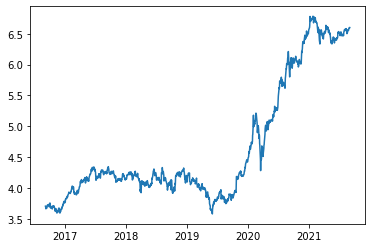

In [63]:
#로그 변환
ts_log_tsla = np.log(ts_tsla)
plt.plot(ts_log_tsla)

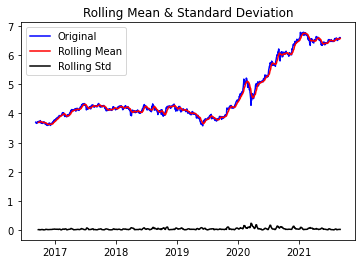

Results of Dickey-Fuller Test:
Test Statistic                    0.393550
p-value                           0.981252
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


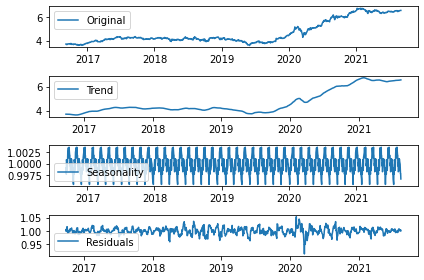

In [64]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log_tsla, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_tsla)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_tsla, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_tsla, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [65]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.063857e+01
p-value                        4.998040e-19
#Lags Used                     1.800000e+01
Number of Observations Used    1.210000e+03
Critical Value (1%)           -3.435766e+00
Critical Value (5%)           -2.863932e+00
Critical Value (10%)          -2.568043e+00
dtype: float64


ADF test에서의 p-value 값은 0.981252로 1에 가까워서 아주 불안정한 시계열로 볼 수 있습니다. residual의 p-value는 4.998040e-19로 아까보다 낮은 값을 보여주고 있습니다. 정상성 시계열로 예측이 가능한 수준이라 생각할 수 있습니다.

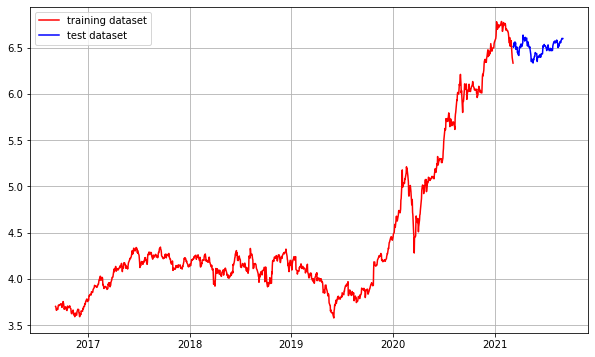

In [66]:
train_data, test_data = ts_log_tsla[:int(len(ts_log_tsla)*0.9)], ts_log_tsla[int(len(ts_log_tsla)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

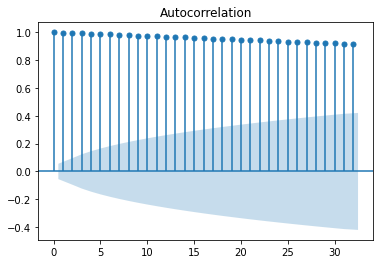

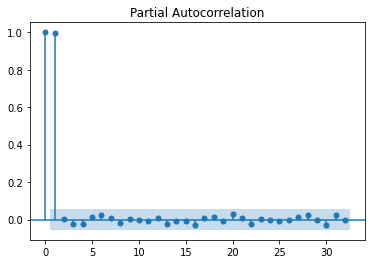

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 적정 ARIMA 모수 찾기
# ACF : Autocorrelation 그래프 그리기
plot_acf(ts_log_tsla)

# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(ts_log_tsla)
plt.show()

AR(1) 모델을 사용하겠습니다.(= p=1)

Results of Dickey-Fuller Test:
Test Statistic                -1.631676e+01
p-value                        3.156553e-29
#Lags Used                     4.000000e+00
Number of Observations Used    1.253000e+03
Critical Value (1%)           -3.435580e+00
Critical Value (5%)           -2.863849e+00
Critical Value (10%)          -2.568000e+00
dtype: float64


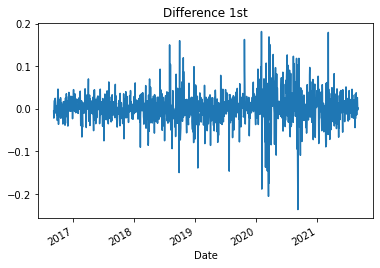

In [74]:
# 차분 안정성 확인, d 구하기
diff_1 = ts_log_tsla.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.222168e+01
p-value                        1.103648e-22
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


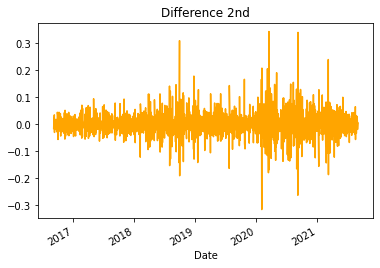

In [75]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd', color='orange')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

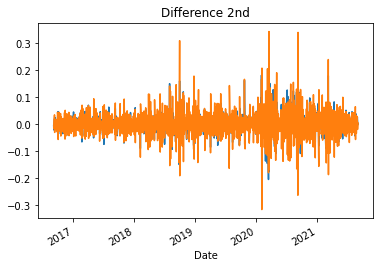

In [76]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

1차 차분을 선택하겠습니다. (= d=1)

### p=1, d=1, q=0 ARIMA 모델

In [72]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1132
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2101.657
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sun, 05 Sep 2021   AIC                          -4197.313
Time:                        02:47:21   BIC                          -4182.218
Sample:                             1   HQIC                         -4191.610
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0023      0.001      2.075      0.038       0.000       0.005
ar.L1.D.Close    -0.0031      0.030     -0.103      0.918      -0.061       0.055
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

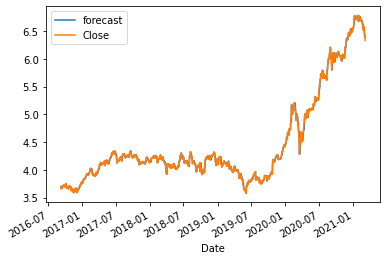

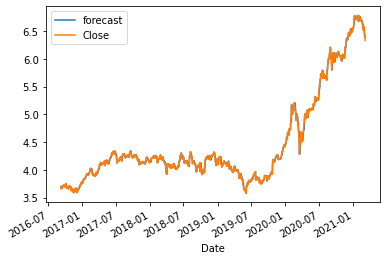

In [77]:
fitted_m.plot_predict()

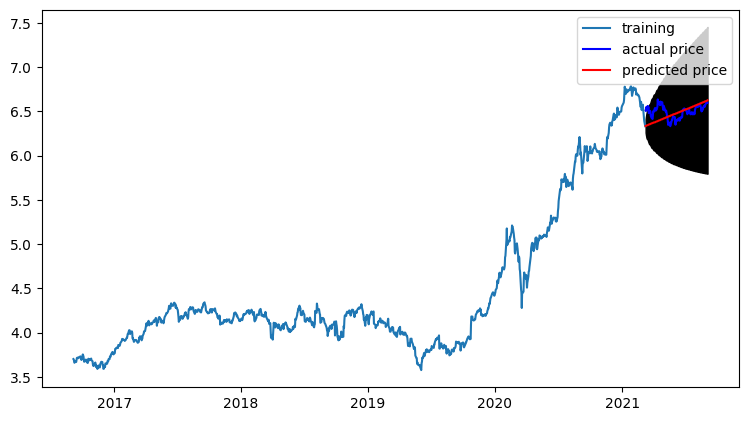

In [78]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
# Forecase : 결과가 fc에 담깁니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% Conf

# Make as pandas series
# 예측 결과
fc_series = pd.Series(fc, index=test_data.index)
# 예측 결과의 하향 바운드
lower_series =pd.Series(conf[:, 0], index=test_data.index)
# 예측 결과의 상향 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k')
plt.legend()
plt.show()

In [79]:
# 로그 변환한 값을 다시 지수 변환

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4373.5545895676505
MAE:  54.1125604706764
RMSE:  66.1328555981643
MAPE: 8.08%


MAPE가 8.08%로  MAPE 15% 미만의 정확도로 잘 예측되었습니다.

# 7-(2) DIS

In [82]:
#결측치 처리
ts_dis = ts_dis.interpolate(method='time')
ts_dis[ts_dis.isna()]

Series([], Name: Close, dtype: float64)

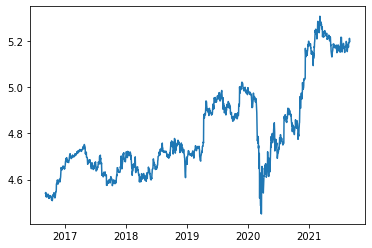

In [83]:
#로그 변환
ts_log_dis = np.log(ts_dis)
plt.plot(ts_log_dis)

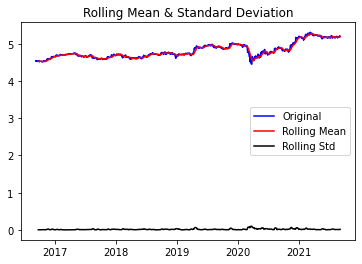

Results of Dickey-Fuller Test:
Test Statistic                   -1.096803
p-value                           0.716345
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


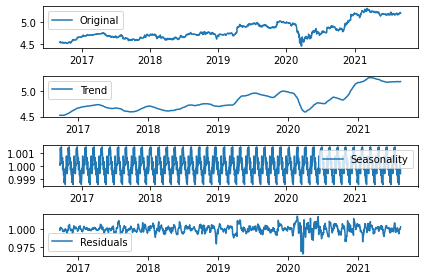

In [84]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log_dis, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_dis)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_dis, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_dis, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

아직까진 p-value 값이 0.716345으로 많이 높은 상황.

In [85]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.144599e+01
p-value                        6.016936e-21
#Lags Used                     1.100000e+01
Number of Observations Used    1.217000e+03
Critical Value (1%)           -3.435735e+00
Critical Value (5%)           -2.863918e+00
Critical Value (10%)          -2.568036e+00
dtype: float64


p-value 값이 6.016936e-21으로 정상성 시계열의 형태라 볼 수 있다. 이를 활용하여 예측 가능!

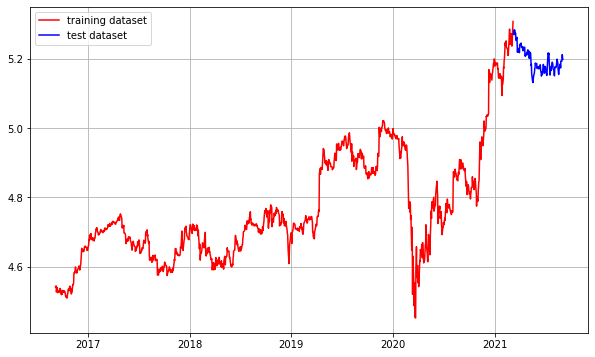

In [86]:
train_data, test_data = ts_log_dis[:int(len(ts_log_dis)*0.9)], ts_log_dis[int(len(ts_log_dis)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

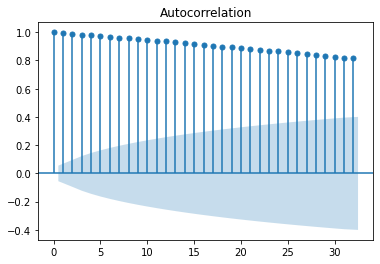

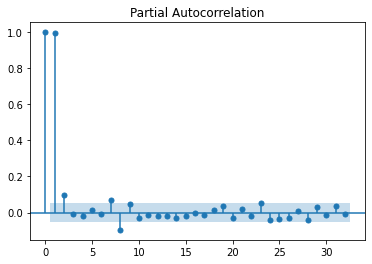

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 적정 ARIMA 모수 찾기
# ACF : Autocorrelation 그래프 그리기
plot_acf(ts_log_dis)

# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(ts_log_dis)
plt.show()

AR(1) 모델을 사용하겠습니다.(= p=1)

Results of Dickey-Fuller Test:
Test Statistic                -1.285667e+01
p-value                        5.214197e-24
#Lags Used                     7.000000e+00
Number of Observations Used    1.250000e+03
Critical Value (1%)           -3.435592e+00
Critical Value (5%)           -2.863855e+00
Critical Value (10%)          -2.568003e+00
dtype: float64


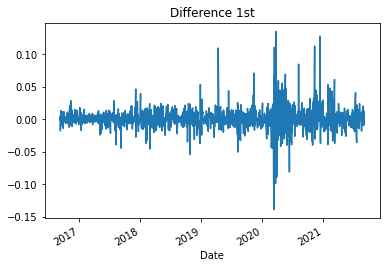

In [89]:
# 차분 안정성 확인, d 구하기
diff_1 = ts_log_dis.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.256765e+01
p-value                        2.036771e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


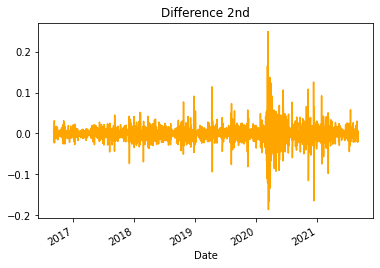

In [90]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd', color='orange')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

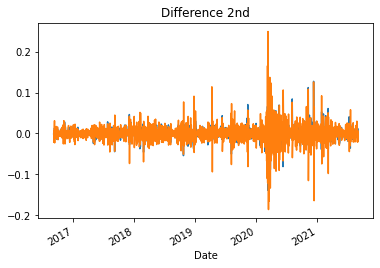

In [91]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

1차 차분을 선택하겠습니다. (= d=1)

### p=1, d=1, q=0 ARIMA 모델

In [92]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1132
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2934.698
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -5863.396
Time:                        02:54:36   BIC                          -5848.301
Sample:                             1   HQIC                         -5857.693
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.432      0.152      -0.000       0.002
ar.L1.D.Close    -0.1493      0.030     -5.056      0.000      -0.207      -0.091
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

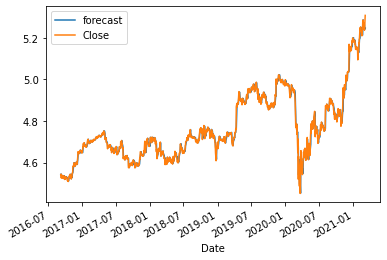

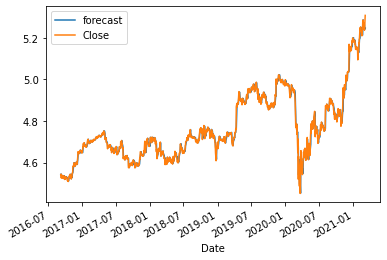

In [93]:
fitted_m.plot_predict()

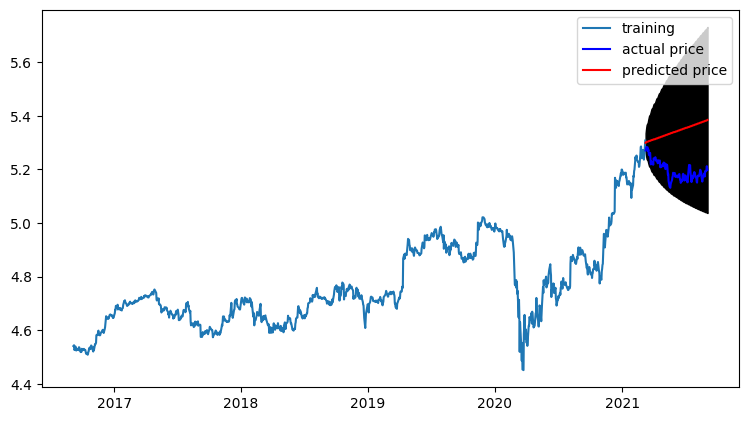

In [94]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
# Forecase : 결과가 fc에 담깁니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% Conf

# Make as pandas series
# 예측 결과
fc_series = pd.Series(fc, index=test_data.index)
# 예측 결과의 하향 바운드
lower_series =pd.Series(conf[:, 0], index=test_data.index)
# 예측 결과의 상향 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k')
plt.legend()
plt.show()

In [95]:
# 로그 변환한 값을 다시 지수 변환

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  920.1912898025098
MAE:  28.50503917678631
RMSE:  30.33465493132417
MAPE: 15.98%


MAPE가 15.98%로 MAPE 15% 이상의 정확도로 최종적으로 예측 모델의 메트릭으로 활용하기에 어려운 결과가 나왔습니다. 여기서 저는 적당한 모수를 선택하지 않았다고 예상할 수 있고, 개선의 여지를 찾아보려고 했습니다.

일반적으로 P,Q 를 간결의 원칙에 따라, P <3 , Q < 3으로 선택하는 것이 이상적입니다. 모형 개수가 증가하면 예측 모형이 복잡해질 뿐 아니라 추정의 효율성도 떨어지기 때에, 모수의 개수가 적은 모형이 좋습니다.

또한, p + q < 2, p x q = 0 인 값들을 많이 사용합니다. (둘중 하나의 모수가 0이라는 것은 실제로 대부분의 시계열 자료에서는 하나의 경향만을 강하게 띄기 때문에, 하나의 모수를 0으로 설정한다)

이번에는 차분 d가 영인 ARIMA(p,q) 모델을 생성해보겠습니다. 이렇게 설정한 근거로는 1차 차분하기 전이 더 정상성을 띄는 유의미한 p-value를 보여주었기 때문입니다.

### p=1, d=0, q=0 ARIMA 모델

In [118]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,0,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1133
Model:                     ARMA(1, 0)   Log Likelihood                2921.667
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -5837.333
Time:                        03:13:03   BIC                          -5822.235
Sample:                             0   HQIC                         -5831.630
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.8263      0.155     31.058      0.000       4.522       5.131
ar.L1.Close     0.9972      0.003    390.612      0.000       0.992       1.002
                                    Roots       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

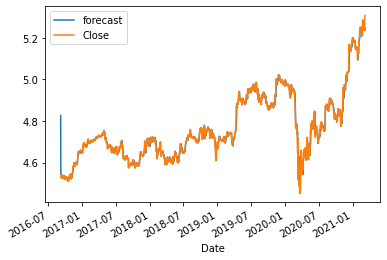

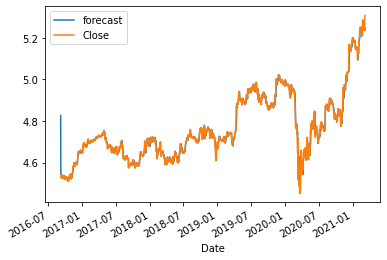

In [119]:
fitted_m.plot_predict()

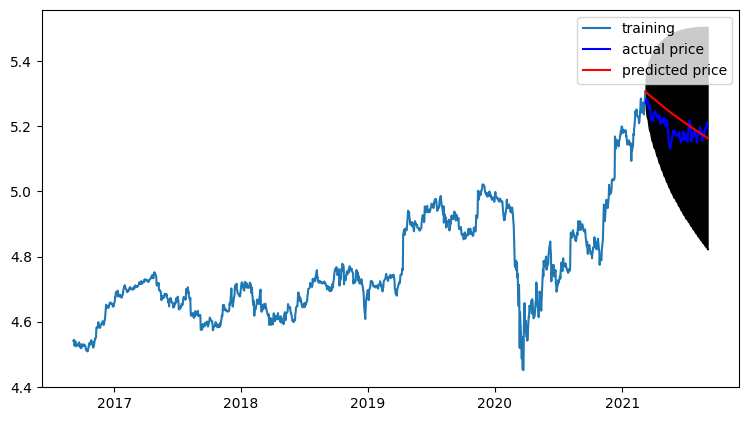

In [120]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
# Forecase : 결과가 fc에 담깁니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% Conf

# Make as pandas series
# 예측 결과
fc_series = pd.Series(fc, index=test_data.index)
# 예측 결과의 하향 바운드
lower_series =pd.Series(conf[:, 0], index=test_data.index)
# 예측 결과의 상향 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k')
plt.legend()
plt.show()

In [121]:
# 로그 변환한 값을 다시 지수 변환

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  74.18017559036964
MAE:  7.481792217471181
RMSE:  8.612791393640602
MAPE: 4.16%


이번엔 4.16%으로 드디어 최종적으로 예측 모델의 메트릭으로 활용할만한 유의미한 값이 나왔습니다. 

# 3. SBUX

In [126]:
#결측치 처리
ts_sbux = ts_sbux.interpolate(method='time')
ts_sbux[ts_sbux.isna()]

Series([], Name: Close, dtype: float64)

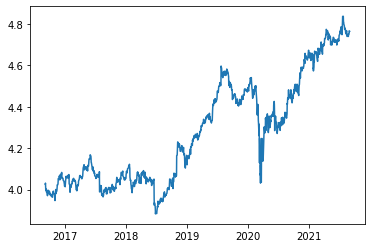

In [127]:
#로그 변환
ts_log_sbux = np.log(ts_sbux)
plt.plot(ts_log_sbux)

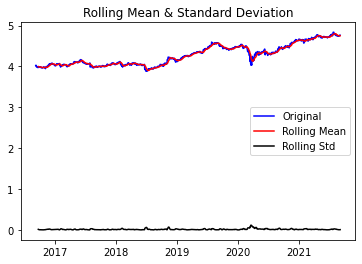

Results of Dickey-Fuller Test:
Test Statistic                   -0.610910
p-value                           0.868498
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


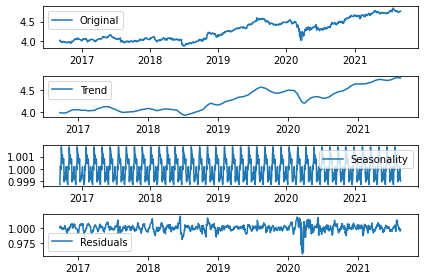

In [128]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log_sbux, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_sbux)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_sbux, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_sbux, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

아직까진 p-value 값이 0.868498으로 많이 높은 상황.

In [130]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.028495e+01
p-value                        3.695681e-18
#Lags Used                     2.000000e+01
Number of Observations Used    1.208000e+03
Critical Value (1%)           -3.435775e+00
Critical Value (5%)           -2.863936e+00
Critical Value (10%)          -2.568045e+00
dtype: float64


p-value 값이 3.695681e-18으로 정상성 시계열의 형태라 볼 수 있다. 이를 활용하여 예측 가능!

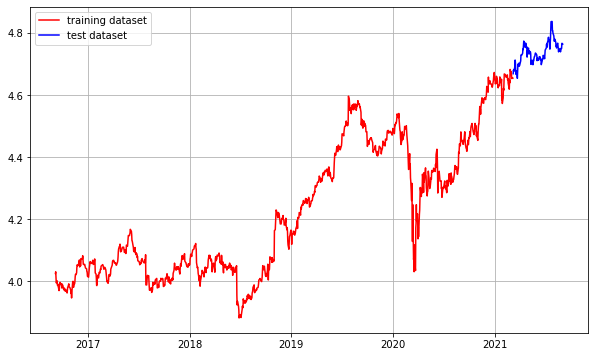

In [132]:
train_data, test_data = ts_log_sbux[:int(len(ts_log_sbux)*0.9)], ts_log_sbux[int(len(ts_log_sbux)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

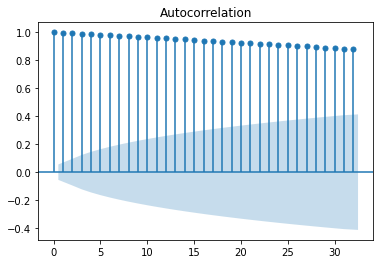

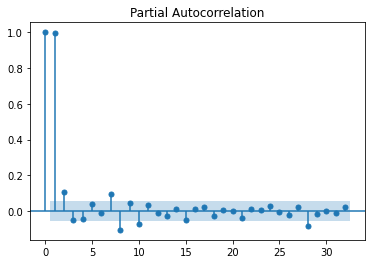

In [134]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 적정 ARIMA 모수 찾기
# ACF : Autocorrelation 그래프 그리기
plot_acf(ts_log_sbux)

# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(ts_log_sbux)
plt.show()

AR(1) 모델을 사용하겠습니다.(= p=1)

Results of Dickey-Fuller Test:
Test Statistic                -1.134606e+01
p-value                        1.026427e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


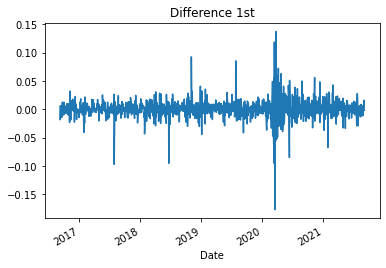

In [135]:
# 차분 안정성 확인, d 구하기
diff_1 = ts_log_sbux.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.381506e+01
p-value                        8.097735e-26
#Lags Used                     1.800000e+01
Number of Observations Used    1.238000e+03
Critical Value (1%)           -3.435643e+00
Critical Value (5%)           -2.863877e+00
Critical Value (10%)          -2.568014e+00
dtype: float64


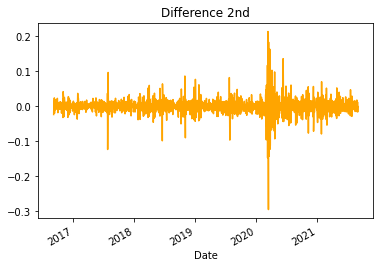

In [136]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd', color='orange')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

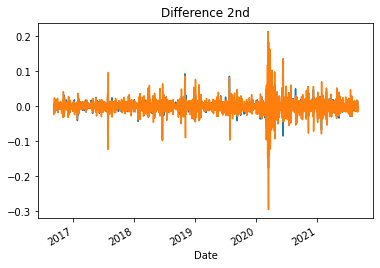

In [137]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

이번엔 1, 2차 차분이 유사한 값을 보이는데 굳이 2차를 사용할 이유는 없으므로 1차를 선택하겠습니다. (= d=1)

### p=1, d=1, q=0 ARIMA 모델

In [138]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1132
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2980.108
Method:                       css-mle   S.D. of innovations              0.017
Date:                Sun, 05 Sep 2021   AIC                          -5954.216
Time:                        03:24:54   BIC                          -5939.121
Sample:                             1   HQIC                         -5948.514
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.253      0.210      -0.000       0.001
ar.L1.D.Close    -0.1677      0.029     -5.726      0.000      -0.225      -0.110
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

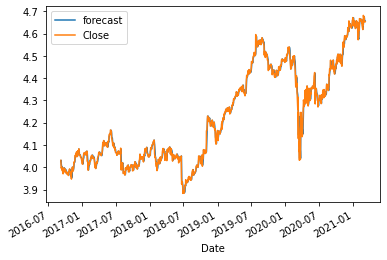

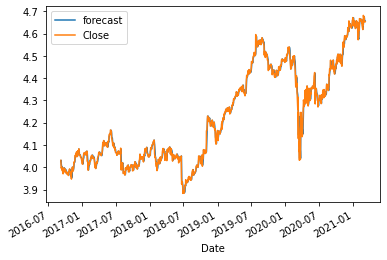

In [139]:
fitted_m.plot_predict()

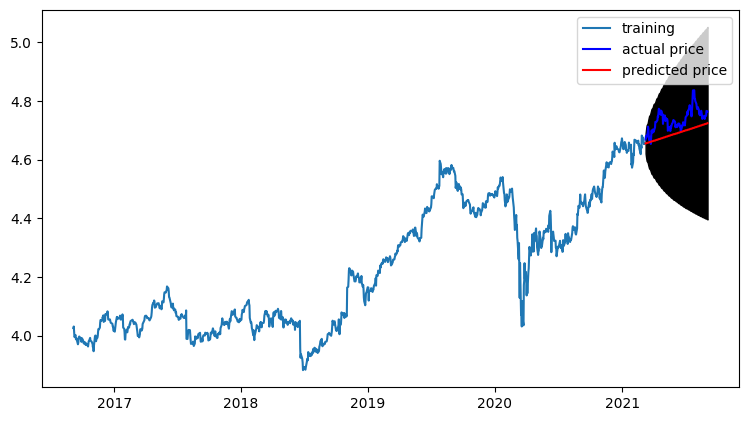

In [140]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
# Forecase : 결과가 fc에 담깁니다.

fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05) # 95% Conf

# Make as pandas series
# 예측 결과
fc_series = pd.Series(fc, index=test_data.index)
# 예측 결과의 하향 바운드
lower_series =pd.Series(conf[:, 0], index=test_data.index)
# 예측 결과의 상향 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k')
plt.legend()
plt.show()

In [141]:
# 로그 변환한 값을 다시 지수 변환

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  38.68076408709787
MAE:  5.352752930939895
RMSE:  6.2193861503445715
MAPE: 4.61%


다행히 마지막 SBUX의 MAPE 값은 4.61%으로 드디어 최종적으로 예측 모델의 메트릭으로 활용할만한 유의미한 값이 나왔습니다!

# 프로젝트 정리

#### 프로젝트하며 도움이 되었던 자료
- 참고 자료 [클릭](https://hwao-story.tistory.com/13)

#### 프로젝트를 위해 직접 열심히 정리한 자료
- [시계열 데이터| 정상성(Stationarity), 차분(differencing), 확률보행, 2차 차분](https://bit.ly/2YfKwQc)
- [통계 개념| 평균, 분산, 공분산, 상관계수, 자기공분산, 자기상관계수](https://bit.ly/3tgEZoa)
- [시계열 패턴(trend, seasonality, cycle), 잔차(Residual)](https://bit.ly/3kUMX2a)
- [자기 회귀(Autoregressive), 이동 평균(Moving average), ARIMA 모델](https://bit.ly/3yCps2U)

#### 느낀 점
- p, d, q의 모수 설정하는 데 있어 아직까지 완벽한 이해를 한 것 같지는 않습니다. 시계열 데이터를 공부하고 예측 결과 등을 비교하고 분석해보며 굉장히 즐거웠지만, 아직은 모수 설정을 어떻게 해야 할 지 어려움이 있었습니다.
- q 값에 대한 이해가 더 필요할 듯 (ACF, PACF 그래프 분석 등)